# "Confidence Intervals for Gamma Distribution Parameters"
> "This is a test"

- toc:true
- badges: true
- comments: true
- author: Luca Cazzanti
- categories: [statistics, gamma]

*This notebook comes from  [The Abacus and The Canvas](http://www.lucacazzanti.net/blog). You may use it and modify it under the terms of the [BSD license](https://opensource.org/licenses).*

<img style="float: right; height: 256px; width: 325px; margin-right: 7px" src= "../images/gammas.png" alt="Gammas" title="Gammas">
I use visualization and bootstrap to obtain empirical confidence intervals for the estimates of the $k$ parameter of a Gamma distribution. I consider the dependency of the estimates on the sample size and on the true value of $k$, and the differences in the estimates computed with the method-of-moment (MoM) and maximum likelihood estimation (MLE). The results are in line with what we already know from statistics:
1. The higher sample size, the higher the achievable confidence for a given tolerance on the $k$ estimates.
2. MLE gives (slightly) more robust estimates than MoM across values of $k$ and across sample sizes.

I also quantify (approximately) the relationship between the confidence level and the fractional error in the estimates for $k$:
At the 95% confidence level, estimates for $k$ deviate from the true value by $\pm$28% (sample size=100), by $\pm$12% (sample size=500), and by $\pm$9% (sample size=1000). These results suggest a minimum sample size in the range 100-500 for reasonable estimates in practical settings, although the acceptable deviation from true $k$ depends on one's application.

Tools used: the `seaborn` statistical visualization module, `scipy`, `pandas`, in addition to `matplotlib`.

The Gamma distribution depends on two parameters, $k$ and $\theta$, and looks like this:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from scipy.stats import gamma
import numpy as np

def make_gammas(ks, thetas, x):
    """
    Make a dataframe of Gamma PDFs.
    
    Args:
        ks (1d array-like): values of k 
        thetas (1d array-like): values of theta
        x (1d array-like): points at which to evaluate the Gamma pdf.
        
    Returns:
    Pandas dataframe where eah column contains the Gamma pdf evaluated at x
    for each pairwise combination of the parameters in ks and thetas.
    """
    
    res = {}
    ordered_keys = []
    for theta in sorted(thetas):
        for k in sorted(ks):
            name = '$k$=' + str(k) + '; $\\theta$=' + str(theta)
            res[name] = gamma.pdf(x, k, scale=theta)
            ordered_keys.append(name)
    
    return pd.DataFrame(res)[ordered_keys]

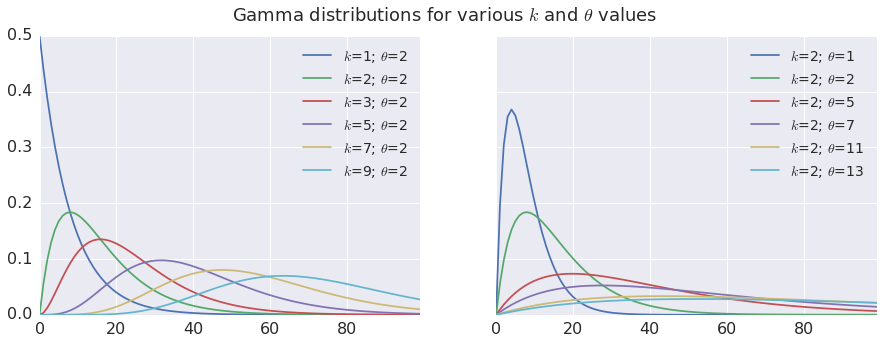

In [2]:
gamma_df_k = make_gammas([1,2,3,5,7,9], [2], np.linspace(0,25, num=100))
gamma_df_theta = make_gammas([2],[1,2,5,7,11,13], np.linspace(0,25, num=100))

fig, axarr = plt.subplots(1,2,figsize=(15,5), sharey=True)
gamma_df_k.plot(ax=axarr[0], fontsize=16)
axarr[0].legend(fontsize=14)
gamma_df_theta.plot(ax=axarr[1], fontsize=16)
axarr[1].legend(fontsize=14)
plt.suptitle('Gamma distributions for various $k$ and $\\theta$ values', fontsize=18)

From the above plots we see that both $k$ and $\theta$ affect the look of the Gamma pdf. The Gamma pdf is skewed to the left, with a longer tail on the right side of the mode. For $k$=1, the Gamma pdf is simply an exponential pdf (maximum asymmetry) and for $k > \approx$9 the pdf approaches a Gaussian (symmetry). Lower values of $\theta$ squish the distribution horizontally toward the left; higher values stretch it and flatten it, but the overall profile is not affected. For these reasons $k$ is called the shape parameter and $\theta$ the scale parameter.

The parameters $k$ and $\theta$ are related to each other through the mean and variance of the Gamma distribution:
$$\mu = k\theta, $$
$$\sigma^2=k\theta^2.$$
Thus, given the mean, we only need to estimate one parameter and then compute the other from the estimate. The `scipy.stats.gamma.fit()` implementation lets you choose which parameter to estimate and which one to constrain: I chose to estimate $k$ and derive $\theta$. Finally, since the Gamma pdf increasingly resembles a Gaussian for higher values of $k$, here I limit my exploration to $k\lt 10$. For higher values a Gaussian might be a better model, or one could shift the data `x` down (to the left) so that `min(x)=0` and assume lower values of $k$ for approximating the shifted pdf. Either way, I look only at $k\lt10$.

## Estimating k in practice and confidence intervals
In pratical settings, a limited number of samples are available, which introduces uncertainty about the estimated value of $k$. We know from probability theory that the uncertainty decreases as the number $n$ of available samples increases: in fact, the uncertainty is inversely proportional to $\sqrt{n}$. One can measure this effect empirically by repeatedly estimating $k$ many times for different sample sizes, and observing the resulting *sampling distribution*: this is called *bootstrap*, and it's the method I adopt here.

With the bootstrap, one can compute the confidence intervals around the estimates. Confidence intervals are simple plus-or-minus bounds associated with the estimated value and with a level of confidence, which is simply the probability that the estimated $k$ will fall within the bounds. Typically folks aim for a 95% confidence interval: what are the bounds within which the true value of $k$ will fall with a probability of 95%? Or, you can turn around the question and ask: Given that I can only tolerate a given bound on the estimation error, what is the probability (confidence) that the estimate will fall within those bounds? 

But how do we estimate $k$? There are two gneral approaches from statistical learning that we can apply here: the MoM and MLE.    

### MoM: Method of moments
With MoM, one sets the empirical moments (mean, variance etc.) to their theoretical expression in terms of the distribution parameters, then solves for the parameters. For a Gamma distribution we know that the mean $\mu=k\theta$ and the variance $\sigma^2=k\theta^2$. So, taking the values of $\mu$ and $\sigma^2$ from the sample, the closed-form solution for $k$ and $\theta$ is:
$$k = \frac{\mu^2}{\sigma^2},$$
$$\theta = \frac{\sigma^2}{\mu}$$

Here's a trivial Python implementation:

In [3]:
import numpy as np
def gamma_mom(x):
    """
    Estimate the parameters of a Gamma distribution using the method-of-moments.
    
     Args:
        x (1d array-like): Data, assumed drawn from a Gamma distribution.
        
    Returns:
        (k, theta) parameters
    """
    
    avg = np.mean(x)
    var = np.var(x)  
    k = avg**2 / var
    theta = var / avg
    
    return k, theta

### MLE: Maximum likelihood estimation
With MLE, one maximizes the likelihood function of the observed the data over the Gamma parameters. For Gamma, there is no closed-form expression for the maximum as a function of the parameters, so we must resort to numerical methods. Luckily `scipy.stats.gamma.fit()` implements MLE for Gamma distributions for us, based on work by [Choi and Wette](https://en.wikipedia.org/wiki/Gamma_distribution) and [Minka](http://research.microsoft.com/en-us/um/people/minka/papers/minka-gamma.pdf).



## MoM and MLE: single $k$
Lets calibrate the discussion to what we already know. For a single value of $k$, let's generate many bootstrap draws the corresponding gamma and compare the sampling distributions for the estimates obtained with the MoM and the MLE.

In [4]:
import itertools

def gamma_bootstrap_estimate(true_k, true_theta, sample_size=[50, 100, 1000], draws=100, method='all'):
    """
    Estimate the parameters of a Gamma distribution with bootstrap.
    Generates bootstrap samples and estimates the (k, theta) parameters from each draw,
    using the method-of-moments and scipy.stats.gamma.fit
    
    Args:
        true_k (scalar): the k parameter of the Gamma distribution.
        true_theta (scalar): the theta parameter of the Gamma distribution.
        sample_size (1d array-like of ints): the number of random samples to draw
            from the Gamma distribution for each bootstrap draw.
        draws (int): number of bootstrap draws (100)
        method (str): one of 'mom', 'scipy', or 'all' ('all')
        
    Returns:
        A pandas DataFrame where each row contains the estimates for k and theta for one bootstrap draw.
        
    """
    
    true_mean = true_k * true_theta
    true_var = true_k * true_theta ** 2
    
    result = []
    for this_many in sample_size:
        
        # Generate this_many samples from the true Gamma
        rvs = [ gamma.rvs(true_k, scale=true_theta, size=this_many) for n in xrange(draws) ]
        
        if method == 'all' or method == 'scipy':
            estimates_scipy = ( gamma.fit(x,floc=0) for x in rvs )
            (k_scipy, loc_scipy, theta_scipy) = itertools.izip(*estimates_scipy)
            result.append({'sample_size': this_many, 'k_estimate': k_scipy, 'theta_estimate': theta_scipy,
                           'true_theta': true_theta, 'true_k': true_k, 'method': 'scipy'})
        
        if method == 'all' or method == 'mom':
            estimates_mom = (gamma_mom(x) for x in rvs)
            (k_mom, theta_mom) = itertools.izip(*estimates_mom)
            result.append({'sample_size': this_many, 'k_estimate': k_mom, 'theta_estimate': theta_mom,
                           'true_theta': true_theta, 'true_k': true_k, 'method': 'mom'})
        
    
    return pd.concat( [pd.DataFrame(r) for r in result])

In [5]:
# Plot one and get a feel for the results
true_k = 2
true_theta = 2
num_samples = [10, 25, 50, 100, 500, 1000]
num_draws = 1000
estimates_for_one_k = gamma_bootstrap_estimate(true_k, true_theta, num_samples, draws=num_draws)
estimates_for_one_k.head()

,k_estimate,method,sample_size,theta_estimate,true_k,true_theta
0,3.465786,scipy,10,0.882095,2,2
1,5.106975,scipy,10,0.797050,2,2
2,3.020494,scipy,10,1.002957,2,2
3,4.314278,scipy,10,1.233048,2,2
4,2.175172,scipy,10,1.090711,2,2


The *violin plot* is a graphical data analysis method for direct comparison of two distributions across different values of a grouping variable (number of samples in our case). Let's take a look: 

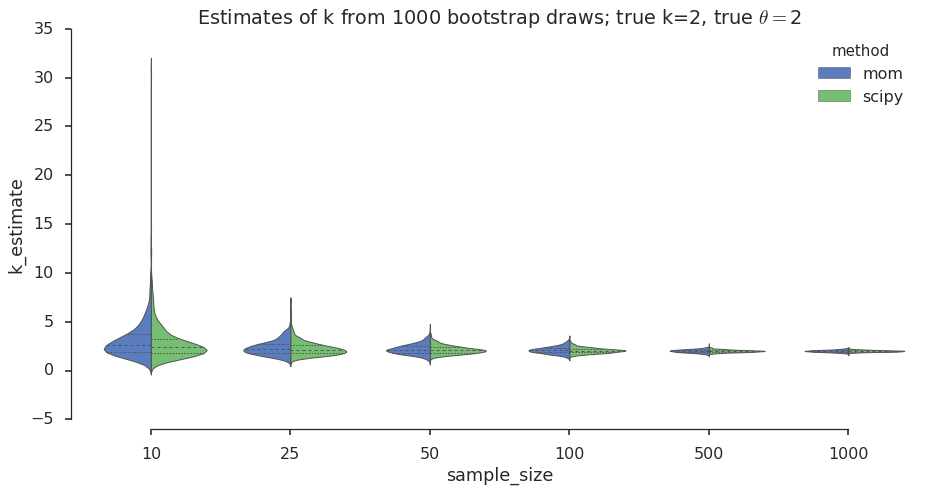

In [6]:
import seaborn as sns
sns.set(style="ticks")
sns.set_context("poster") # this helps when converting to static html for blog

plt.figure(figsize=(15,7))
ax = sns.violinplot(x='sample_size', y='k_estimate', data=estimates_for_one_k, hue='method', palette='muted',
               inner='quartile', split=True, hue_order=['mom', 'scipy'], linewidth=1)
sns.despine(offset=10, trim=True)
title_str = 'Estimates of k from ' + str(num_draws) + \
    ' bootstrap draws; true k=' + str(true_k) + \
    ', true $\\theta=$' + str(true_theta)
plt.title(title_str)

### Observations on the violin plot
I see that for both MoM and MLE the sampling distribution spread decreases as the number of samples increases. We knew his from the central limit theorem (CLM). I also see  that the spread of the sampling distribution for the MoM estimates is a bit wider than for the MLE, which suggests that MLE could buy you a bit more confidence in the estimates. Next I want to look at these differences in spread more closely and test these observations for different values of $k$.

## MoM and MLE: many $k$s

To compare the estimates across $k$, I normalize the error to a fraction between -1 and 1. I stop at k=9 because for higher values the Gamma distribution starts to look like a Gaussian, and a Gaussian model might be sufficient in practical settings. I visualize the results in panels of *boxplots*, which help hone in on the quartiles of a distribution.

In [7]:
df_list = []
theta_val = 2
for k in [1,2,3,5,7,9]:
    tmp = gamma_bootstrap_estimate(k,theta_val, sample_size=num_samples, draws=num_draws)
    df_list.append(tmp)

big_df = pd.concat(df_list)   
big_df['fractional_error'] = (big_df['k_estimate'] - big_df['true_k'] ) / big_df['true_k']
big_df.head()

,k_estimate,method,sample_size,theta_estimate,true_k,true_theta,fractional_error
0,1.229787,scipy,10,1.059610,1,2,0.229787
1,0.790053,scipy,10,3.453050,1,2,-0.209947
2,0.975968,scipy,10,1.461941,1,2,-0.024032
3,1.004771,scipy,10,1.284221,1,2,0.004771
4,0.754723,scipy,10,1.668499,1,2,-0.245277


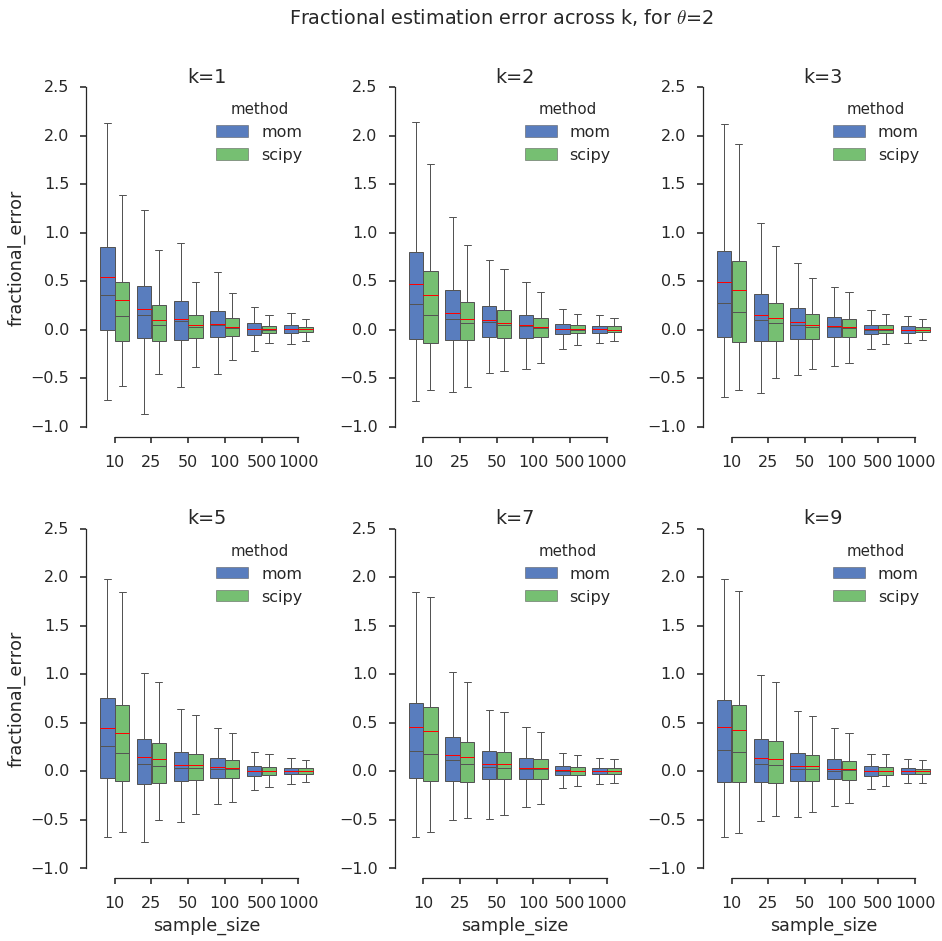

In [8]:
# A change in matplotlib has broken Seaborn FacetGrid() when used with boxplots with the hue argument, so I have to
# make and adjust the subplots manually...
true_k = big_df['true_k'].unique()
num_k = len(true_k)
ncol=3
nrow= num_k / ncol

sns.set(style="ticks")
sns.set_context("poster")
f, axarr = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(15,14))
for row in range(nrow):
    for col in range(ncol):
        idx = row * ncol + col
        this_ax = axarr[row,col]
        sns.boxplot(ax=this_ax, x="sample_size", y="fractional_error", hue='method', hue_order=['mom', 'scipy'],
                    data=big_df[big_df['true_k'] == true_k[idx] ], palette="muted",
                    showfliers=False,  linewidth=1, showmeans=True, meanline=True)
        this_ax.set_title('k='+str(true_k[idx]))
        if row == 0:
            this_ax.set_xlabel('')
        if col > 0:
            this_ax.set_ylabel('')

sns.despine(offset=10, trim=True)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.suptitle('Fractional estimation error across k, for $\\theta$='+str(theta_val))

### Observations on the box plots
In the above grid of box plots I notice the following: 
1. It seems that the MLE and MoM are not dependent on the true value of $k$, except that for $k=1$, for which the Gamma becomes an exponetial pdf, the MoM gives visually noticeable higher error.
2. MLE gives more robust estimates, which show up as smaller inter-quantile ranges (IQRs, the upper and lower box edges)
3. The median and mean fractional error (black and red lines, respectively, inside the boxes) for both MLE and MoM are consistently greater than 0, which tells me that the sampling distribution is skewed. This effect is particularly noticeable for sample sizes 10 and 25. Mean and median converge toward each other and toward 0 for larger sample sizes, which means that the sampling distributions become more symmetric. We observed this in the violin plots above, too, and it is expected by the central limit theorem (CLT).

## Confidence intervals
I want to eastimate confidence intervals, so I compute quantiles of the estimates of $k$. Again, to facilitate the comparison across different true values of $k$ and across sample sizes I adopt the fractional error metric, but I take its absolute value to simplify the visual exploration of the charts below. In this case taking the absolute value is like assuming that the fractional error is symmetric around 0. We have seen above that this is not the case for small sample sizes, but for sample size 100 and greater it is more plausible. Nonetheless, for the purpose of this blog, please allow me to simplify in this way.

Finally, to avoid visual information overload, I do not color-code the different values of $k$ in the quantile plots below. Instead, estimates for different $k$s are color-coded by estimation method, so the plots will display 6 markers per method per confidence level, color-coded by MoM or MLE. This visualization is clearer and consistent with the observation that the true value of $k$ has a smaller effect on the estimates than the sample size. Here we go!

In [9]:
q = [0.05,0.1,0.2,0.3, 0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 0.975] #quantiles
big_df['abs_fractional_error'] = big_df['fractional_error'].abs()
grouped = big_df.groupby(['method', 'sample_size', 'true_k'])
grouped_quantiles = grouped['abs_fractional_error'].quantile(q)
grouped_quantiles.name='fractional_error_quantile'

# Give a name to the quantile level column
grouped_quantiles.index.names = map(lambda n: n if n is not None else 'confidence_level', grouped_quantiles.index.names)

# Flatten the results for easier plotting: Took me a while poking around
# the pandas doc to find this way to flatten the multi-index created by groupby() above!
quantiles_df = pd.DataFrame( pd.DataFrame(grouped_quantiles).to_records() )
quantiles_df.head()

,method,sample_size,true_k,confidence_level,fractional_error_quantile
0,mom,10,1,0.05,0.034163
1,mom,10,1,0.10,0.062888
2,mom,10,1,0.20,0.132973
3,mom,10,1,0.30,0.211379
4,mom,10,1,0.40,0.312867


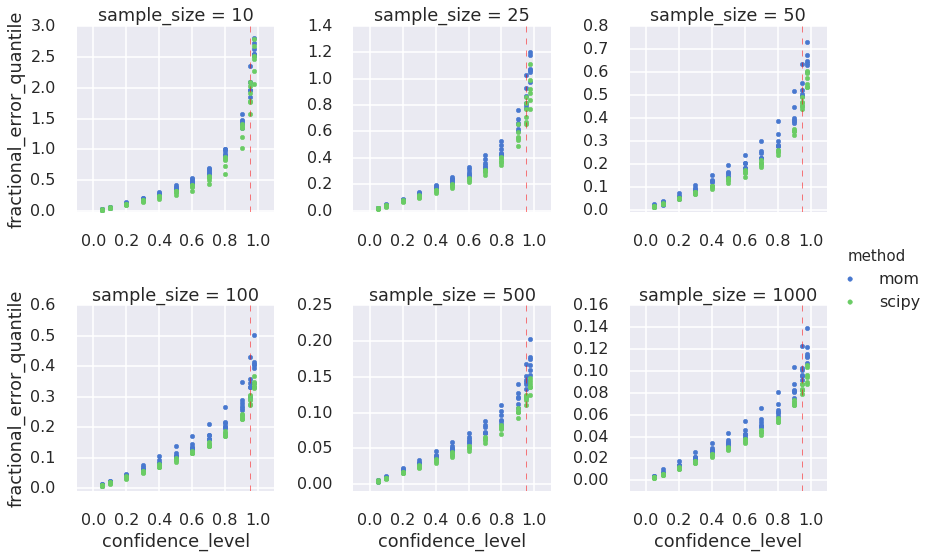

In [10]:
sns.set(style="darkgrid")
sns.set_context("poster")
f = plt.figure(figsize=(17,15))
g = sns.FacetGrid(quantiles_df, despine=True, sharey=False, col_wrap=3, col='sample_size', size=4, legend_out=True,
                  hue='method', hue_order=['mom', 'scipy'], margin_titles=True, palette='muted', xlim=[-0.1, 1.1])
g.map(plt.scatter, "confidence_level", "fractional_error_quantile")

# Adjust ylims and plot vertical line at a given confidence level
conf_level = 0.95
for ax in g.axes.flat:
    ylims = ax.get_ylim()
    new_ylims = [-0.01, ylims[1]]
    ax.set_ylim(new_ylims)
    ax.plot([conf_level, conf_level], new_ylims, 'r--', alpha=0.5, linewidth=1)
    
sns.despine(offset=10, trim=True)
g.add_legend()
g.fig.subplots_adjust(wspace=0.4, hspace=0.5);

### Observations on the quantile plots
1. Our previous observation that MLE gives more robust estimates than MoM across sample sizes and values of $k$ is confirmed: MLE depends less on the value of $k$ (tighter green vertical spreads)  and, for equal confidence level, gives less fractional error in the estimated $k$ (green plots consistently lower than blue plots).
2. For sample sizes <=50, at a 95% confidence level (red vertical line) you'd need to tolerate uncertainties in $k$ between about $\pm$ 40% to $\pm$ 200%. Perhaps your application can deal with this range, perhaps not.
3. For sample sizes >= 100, the confidence intervals become more reasonable: for 500 samples the 95% confidence interval is about $\pm$ 12% for MLE, and about $\pm9$% for 1000 samples.



## Summary
I explored the link between sampling size, Gamma distribution parameters, and estimation methods using the bootstrap and visualization. What I found is well known, not just for Gamma distributions: sampling effects diminish as the sample size increases and different estimation methods give different results. I was also interested in calculating confidence intervals on the estimates that I could use a guidelines in the future. I now know, for example, that if I want my estimate of $k$ to be within $\pm$15% of true value 95% of the times, I need about 500 samples. In fact, I suggest two guidelines:
1. Prefer MLE over MoM for Gamma distributions because it buys you a bit more confidence.
2. Prefer sample sizes > 100, but 1000, or even 500 may not be necessary, depending on the requirements of your application.

## Relevance: why does it matter?  
Sampling introduces uncertainty in addition to the randomness of your chosen probability model. You should have an idea about this additional uncertainty, because it affects the predictions downstream of the estimation and therefore your key performance indicators (KPIs). In a typical data product (recommendation engine, personalized marketing offer, etc.), you have an overall error budget dictated by the allowed tolerances of your problem, and you allocate that error budget to the various steps in your data processing pipeline. For example, say your KPI is average revenue per user (ARPU) and you must estimate it within $\pm5%$, then all steps in your pipeline must guarantee that you will stay within that limit.

It's true that big data give us the luxury of huge sample sizes, compressing the uncertainty down to [unreasonably effective ranges](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf), and making sampling effects essentially insignificant. But even when you have big data sets available, you may need to partition it into many, disjoint subsets to run hundreds or thousands of independent experiments, each one requiring some sort of parameter estimation. This is the case of *mass personalization*, for example, in which finely targeted marketing offers are presented to smallish groups of customers. Determining the appropirate offer requires running many A/B tests, which means reserving target and control groups for each test. If each one requires 100 customers and you have 100 offers to test, then you need 10,000 customers set aside. If you are Google or Facebook that's peanuts, but if you are a startup you may not have that meny customers to experiment with. So, 
You should strive to minimize the number of samples (in this case customers) needed for eaxh experiment, which means that you must know the additional uncertainty you introduce when you make your sample sizes smaller. This will help you  consider more carefully how the uncertainty propagates through the steps of your data analysis and how it affects your KPIs.

Download the [Jupyter Notebook](/blog/downloads/notebooks/EstimatingGammaParameters.ipynb) used to create this post.